In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
%matplotlib inline
np.random.seed = 0

# Data (normal distribution)

In [3]:
nb_pts = 1000
x = pd.Series(np.random.normal(size=(nb_pts)), index=range(nb_pts))

# Theory

http://www.math.uni.edu/~campbell/stat/normfact.html

Understanding what the normal distribution means is enhanced by being familiar with a few z-scores and their associated areas.

### 68-95 rule
It is readily calculated that 68% (.6826) of normally distributed data is within one standard deviation of the mean (between -1 and 1). 

Similarly, 95% (.9544) is within two standard deviation units of the mean, and 99.7% (.9974) is within three standard deviation units of the mean.

### Quartiles
It is readily calculated that for the standard normal distribution the first quartile is -.67 (using .2514 for .25) and the third quartile is .67. 

This means that for normally distributed data, one-half of the data is within 2/3 of a standard deviation unit of the mean.

### Outliers
One definition of outliers is data that are more than 1.5 times the inter-quartile range before Q1 or after Q3. Since the quartiles for the standard normal distribution are +/-.67, the IQR = 1.34, hence 1.5 times 1.34 = 2.01, and outliers are less than -2.68 or greater than 2.68. 

Hence for normally distributed data, the probability of being an outlier is 2 times .0037 = .0074. This is less than 1%. 

In [4]:
theoretical_IQR = 1.34
theoretical_up_limit = 2.68
theoretical_down_limit = -2.68

In [5]:
# computing the probability of observing x greater than (or lower than) a given value (Cumulative Distribution Function)

print(f'the probability of observing x < -3 is {norm.cdf(-3)}')
print(f'the probability of observing x > 3  is {1. - norm.cdf(3)}')

the probability of observing x < -3 is 0.0013498980316300933
the probability of observing x > 3  is 0.0013498980316301035


# Simple descriptive statistics

In [6]:
x.describe()

count    1000.000000
mean       -0.024452
std         1.039661
min        -3.155672
25%        -0.739921
50%        -0.016778
75%         0.657767
max         3.009085
dtype: float64

In [7]:
# computing inter quartile range
IQR = x.quantile(0.75) - x.quantile(0.25)

print(f'sample IQR={IQR}, theoretical IQR = {theoretical_IQR}')

sample IQR=1.3976882790084049, theoretical IQR = 1.34


In [8]:
# extreme values in normal distributed data are considered to be either above Q3 + 1.5 IQR or below Q1 - 1.5 IQR

up_limit = x.quantile(0.75) + 1.5 * IQR
down_limit = x.quantile(0.25) - 1.5 * IQR

print(f'sample outliers boundaries: {down_limit} - {up_limit}\ntheoretical : {theoretical_down_limit} - {theoretical_up_limit}')

sample outliers boundaries: -2.8364537237086846 - 2.754299392324935
theoretical : -2.68 - 2.68


# Visualizations

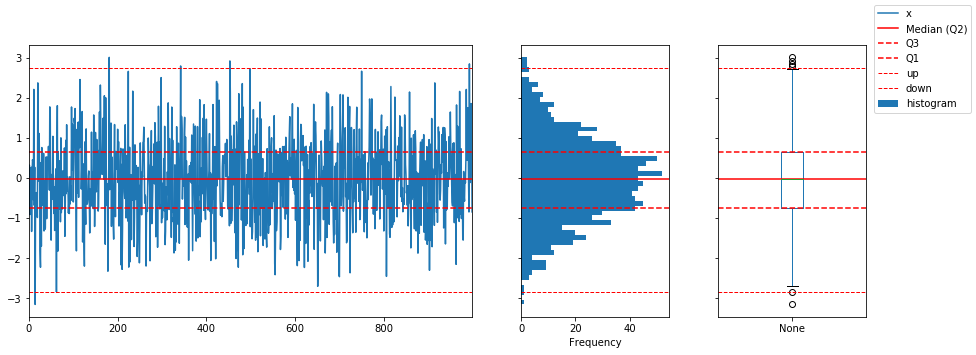

In [9]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [3, 1, 1]})
# time plot with median Q1 and Q3 displayed
x.plot(ax=axes[0], label='x')
axes[0].axhline(x.median(), color='r', label='Median (Q2)')
axes[0].axhline(x.quantile(0.25), color='r', linestyle='--', label='Q3')
axes[0].axhline(x.quantile(0.75), color='r', linestyle='--', label='Q1')
axes[0].axhline(up_limit, color='r', linestyle='--', linewidth=1, label='up')
axes[0].axhline(down_limit, color='r', linestyle='--', linewidth=1, label='down')
# histogram
x.plot.hist(bins=50, orientation=u'horizontal', ax=axes[1], label='histogram')
axes[1].axhline(x.median(), color='r')
axes[1].axhline(x.quantile(0.25), color='r', linestyle='--')
axes[1].axhline(x.quantile(0.75), color='r', linestyle='--')
axes[1].axhline(up_limit, color='r', linestyle='--', linewidth=1)
axes[1].axhline(down_limit, color='r', linestyle='--', linewidth=1)
# boxplot
x.plot.box(ax=axes[2])
axes[2].axhline(x.median(), color='r')
axes[2].axhline(x.quantile(0.25), color='r', linestyle='--')
axes[2].axhline(x.quantile(0.75), color='r', linestyle='--')
axes[2].axhline(up_limit, color='r', linestyle='--', linewidth=1)
axes[2].axhline(down_limit, color='r', linestyle='--', linewidth=1)
fig.legend();

# Preparing data for outliers detection (with PyOD)

In [10]:
is_outlier = ((x > up_limit) | (x < down_limit))

df = pd.concat([x, is_outlier], axis=1, keys=['x', 'is_outlier'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
x             1000 non-null float64
is_outlier    1000 non-null bool
dtypes: bool(1), float64(1)
memory usage: 8.9 KB


In [12]:
df.head()

,x,is_outlier
0,0.245487,False
1,0.321217,False
2,-0.914952,False
3,0.152731,False
4,0.062330,False


In [13]:
print(f'Number of theoretical outliers: {len(df[df.is_outlier])}')
print(f'Number of theoretical  inliers: {len(df[~df.is_outlier])}') 
print(f'Percentage of outliers (contamination): {len(df[df.is_outlier]) * 1. / len(df)}') 

Number of theoretical outliers: 6
Number of theoretical  inliers: 994
Percentage of outliers (contamination): 0.006


In [14]:
# formating data for the algorithm (should be a 2D numpy array, see sklearn API)
X=x.values.reshape(-1, 1)

# Isolation forest

https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In [15]:
from pyod.models.iforest import IForest

In [41]:
# creating the outlier detector
detector_iforest = IForest(
    n_estimators=100, # the number of 
    max_samples=0.8, 
    contamination=0.006, 
    max_features=1.0, 
    bootstrap=False,
    behaviour='new',
    random_state=0, 
    verbose=0)

In [42]:
# "fitting" the detector = letting it do its job ;)
detector_iforest.fit(X)

IForest(behaviour='new', bootstrap=False, contamination=0.006,
    max_features=1.0, max_samples=0.8, n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [43]:
# adding the outlier score to our dataframe
df['isolation_forest_score'] = detector_iforest.decision_scores_
df['isolation_forest_outliers'] = detector_iforest.predict(X)

### Visualizing the "outlierness" score computed by the isolation forest algorithm

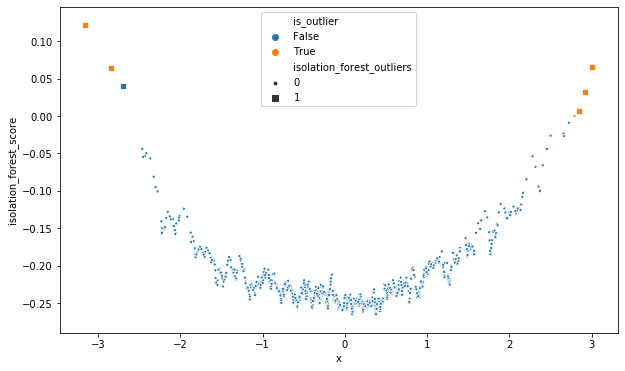

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=df, 
    x='x', 
    y='isolation_forest_score', 
    hue='is_outlier',
    style='isolation_forest_outliers',
    markers={0:'.',1:'s'},
    ax=ax
)

### Evaluating isolation forest

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
confusion_matrix(y_true=df.is_outlier.astype(int), y_pred=df.isolation_forest_outliers)

array([[993,   1],
       [  1,   5]], dtype=int64)

# K Nearest Neighbors

https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn

In [22]:
from pyod.models.knn import KNN

In [47]:
detector_knn = KNN(
    contamination=0.006,
    n_neighbors=5,
    method='largest',
    radius=1.0,
    algorithm= 'ball_tree',
    leaf_size=30,
    metric='minkowski',
    p=2
)

In [48]:
detector_knn.fit(X)

KNN(algorithm='ball_tree', contamination=0.006, leaf_size=30,
  method='largest', metric='minkowski', metric_params=None, n_jobs=1,
  n_neighbors=5, p=2, radius=1.0)

In [49]:
# adding the outlier score to our dataframe
df['knn_score'] = detector_knn.decision_scores_
df['knn_outliers'] = detector_knn.predict(X)

### Visualizing the "outlierness" score computed by the KNN algorithm

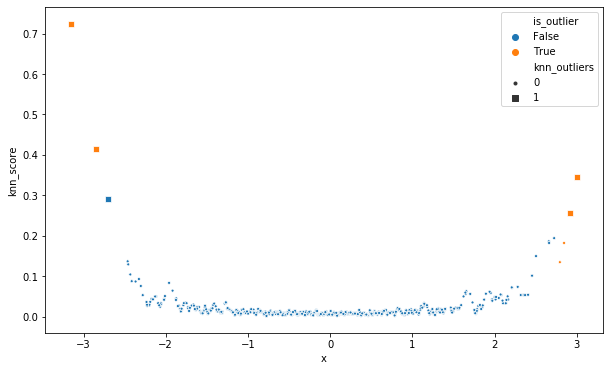

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(
    data=df, 
    x='x', 
    y='knn_score', 
    hue='is_outlier',
    style='knn_outliers',
    markers={0:'.',1:'s'},
    ax=ax
)

### Evaluating isolation forest

In [51]:
confusion_matrix(y_true=df.is_outlier.astype(int), y_pred=df.knn_outliers)

array([[993,   1],
       [  2,   4]], dtype=int64)